## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:150%; text-align:left;padding:3.0px; background: #607BB0; border-bottom: 8px solid #53599A; border-radius: 5px;">Differences between PIT and TTC credit scoring models<br><div>

**The project is in progress.** The main idea of this notebook is:
    
- to present the theoretical background behind risk rating philosophy, i.e. point in time (PIT) and through the cycle (TTC) models;
- provide practical examples how the model's stability could be evaluated. 
    
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:100%; text-align:left;padding:3.0px; background: #607BB0; border-bottom: 8px solid #53599A; border-radius: 5px;">Table of contents<br><div>
<a id="toc"></a>
- [1 Theory](#1)
    - [1.1 TTC vs PIT models](#1.1)
- [2 Prepare project](#2)
    - [2.1 Load data](#2.1)
    - [2.2 Feature engineering](#2.2)
- [3 Feature analysis](#3)
    - [3.1 Historical default rates](#3.1)
    - [3.2 Train/test/valid split](#3.2)
        - [3.2.1 Out-of-time split](#3.2.1)
        - [3.2.2 Random split](#3.2.2)
        - [3.2.3 Compare splits](#3.2.3)
- [4 Modeling](#4)
- [5 Model validation](#5)
- [6 Submit predictions](#6)
- [7 Changelog](#7)
- [Refencences](#8)    

<a id="1"></a>
# <b>1 <span style='color:#53599A'>Theory</span></b>

<a id="1.1"></a>
## <b>1.1 <span style='color:#53599A'>TTC vs PIT models</span></b>

Originally point in time (**PIT**) and through the cycle (**TTC**) model credit scoring model definitions were introduced by the Basel committee in the early 2000s [**[1]**](#ref1). In the recent European Banking Authority report [**[2]**](#ref2), much more emphasis was placed on the rating philosophy,i.e. how the business cycle interacts with the
related systematic variability in default experience when evaluating models' stability. This means that before to any validation it should be identified whether the model is PIT, TTC, or in between, i.e. hybrid. 

Let's investigate those two edge cases. During the economic cycle, one can observe periods/quarters of increased observed default rates (**ODF**), i.e. economic downturn. There are also periods considered "good times", e.g. e.g. low-interest rates, when low default rates are observed.

![TTC vs PIT](https://www.dropbox.com/scl/fi/6qa7ezn0q43lpmye28h3d/ttc_pit_1.png?rlkey=8ipxfnncd09ywsenobeoxvkxs&dl=1)

PIT models are sensitive to the economic cycle and reflect the borrower’s current ability to repay debt. On the other hand, TTC models are less sensitive to economic cycles and reflect the borrower’s ability to repay debt over an entire economic cycle. Hybrid models fall somewhere in between. These models are used for different risk management purposes.

<a id="1.2"></a>
## <b>1.2 <span style='color:#53599A'>Data litimations</span></b>

**TODO**

<a id="1.3"></a>
## <b>1.3 <span style='color:#53599A'>Estimating model's time horizon</span></b>

**TODO**

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

<a id="2"></a>
# <b>2 <span style='color:#53599A'>Prepare project</span></b>

Load required Python packages, project data and create some new features.

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [1]:
# data processing libraries
import polars as pl
import numpy as np
import pandas as pd

# LightGBM modeling
import lightgbm as lgb

# sklearn functions
from sklearn.model_selection import train_test_split
# for validating models
from sklearn.metrics import roc_auc_score, roc_curve

# for visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
# define default colors for plots in notebook
from matplotlib import cycler
from matplotlib.colors import LinearSegmentedColormap
COLORS = ["#068D9D", "#53599A", "#607BB0", "#6D9DC5", "#77BECF", "#80DED9", "#AEECEF"]
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True, prop_cycle=cycler('color', COLORS))

# to save all trained models
ALL_MODELS = dict()

# constants
PATH = "/kaggle/input/home-credit-credit-risk-model-stability/"
SEED = 123

<a id="2.1"></a>
## <b>2.1 <span style='color:#53599A'>Load data</span></b>

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook
    """
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook
    """
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
# training dataset
train_basetable = pl.read_csv(PATH + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(PATH + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(PATH + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(PATH + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(PATH + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(PATH + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
# test dataset
test_basetable = pl.read_csv(PATH + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(PATH + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(PATH + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(PATH + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(PATH + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(PATH + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(PATH + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

<a id="2.2"></a>
## <b>2.2 <span style='color:#53599A'>Feature engineering</span></b>

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

<a id="3"></a>
# <b>3 <span style='color:#53599A'>Feature analysis</span></b>

<a id="3.1"></a>
## <b>3.1 <span style='color:#53599A'>Historical default rates</span></b>

There are 22 months or 5.5 quarters of data provided. In 2020-04 one can observe a sharp decrease of ODF. In addition, the number of observations also is smaller as compared to periods before 2020-04 (see right y-axis label).

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

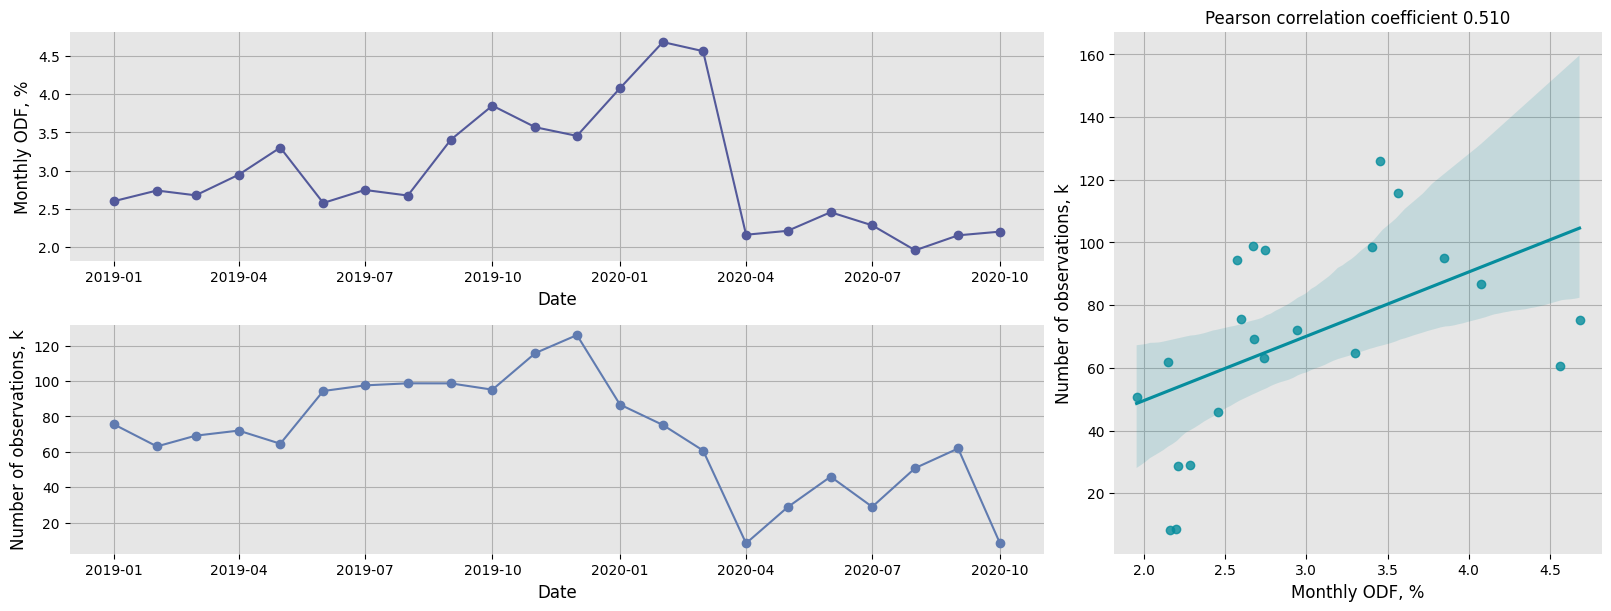

In [7]:
# select data for plotting
df_plot = data[['MONTH', 'target']].to_pandas().groupby('MONTH').agg({'target': ['mean', 'count']}).reset_index()
df_plot.columns = ["".join(_) for _ in df_plot.columns]
# convert to date
df_plot['Date'] = pd.to_datetime(df_plot['MONTH'], format='%Y%m', errors='coerce')

fig = plt.figure(constrained_layout=True, figsize=(16, 6))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[1, :-1])
ax3 = fig.add_subplot(gs[:, -1:])

ax1.plot(df_plot["Date"], df_plot['targetmean'] * 100, "o-", color = COLORS[1])
ax2.plot(df_plot["Date"], df_plot['targetcount'] / 1_000, "o-", color = COLORS[2])
sns.regplot(x=df_plot['targetmean'] * 100, y=df_plot['targetcount'] / 1_000, ax=ax3)
# calculate correlation Pearson coefficient
_corr = df_plot[['targetmean', 'targetcount']].corr().iloc[0, 1]

ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Monthly ODF, %", fontsize=12)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Number of observations, k", fontsize=12)
ax3.set_xlabel("Monthly ODF, %", fontsize=12)
ax3.set_ylabel("Number of observations, k", fontsize=12)
ax3.set_title(f"Pearson correlation coefficient {_corr:.3f}");

80% of observations are up to `2020-FEB`.  while 84.7% up to structural change.

In [8]:
df_plot["targetcount_cumsum"] = df_plot['targetcount'].cumsum()
df_plot["Share, %"] = (df_plot["targetcount_cumsum"] / df_plot['targetcount'].sum() * 100).round(3)
_df = df_plot[["Date", "targetcount", "targetcount_cumsum", "Share, %"]]
_df.columns = ["Date", "Observations, N", "Observations cumsum, N", "Share, %"]
_df

,Date,"Observations, N","Observations cumsum, N","Share, %"
0,2019-01-01,75529,75529,4.947
1,2019-02-01,63064,138593,9.078
2,2019-03-01,69147,207740,13.607
3,2019-04-01,72012,279752,18.324
4,2019-05-01,64594,344346,22.556
5,2019-06-01,94398,438744,28.739
6,2019-07-01,97566,536310,35.130
7,2019-08-01,98741,635051,41.597
8,2019-09-01,98706,733757,48.063
9,2019-10-01,95149,828906,54.295


<a id="3.2"></a>
## <b>3.2 <span style='color:#53599A'>Train/test/valid split</span></b>

Let's investigate the differences of model's performance which depends on how train/test/validation samples were split:

* random splitting;
* out-of-time splitting.

<a id="3.2.1"></a>
## <b>3.2.1 <span style='color:#53599A'>Out-of-time splitting</span></b>

Instead of a random splitting, out of time splitting is should used in order to access historical economical conditions.

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

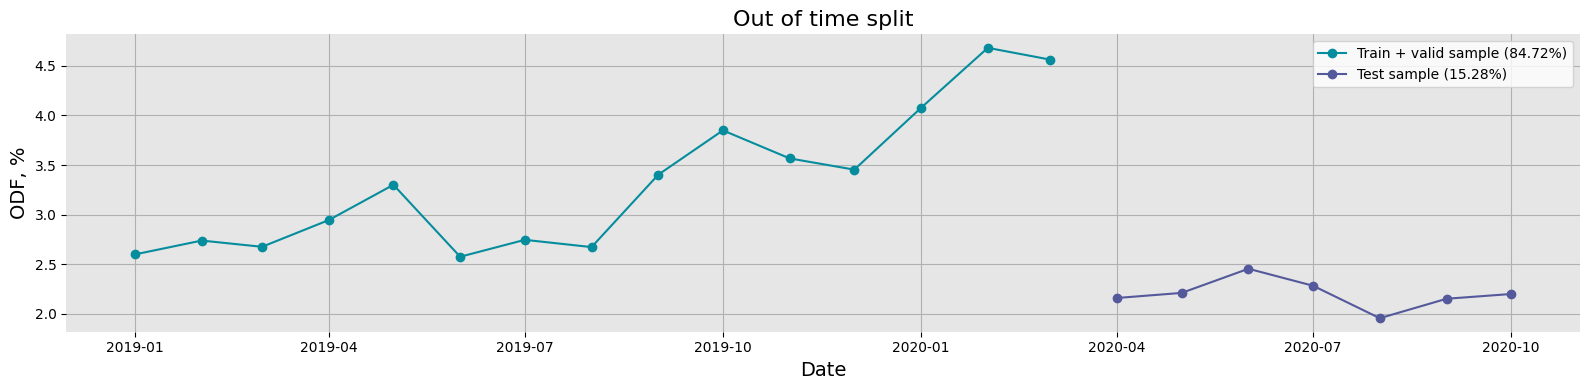

In [9]:
# select data for plotting
df_plot = data[['MONTH', 'target']].to_pandas().groupby('MONTH').agg({'target': ['mean', 'count']}).reset_index()
df_plot.columns = ["".join(_) for _ in df_plot.columns]
# convert to date
df_plot['Date'] = pd.to_datetime(df_plot['MONTH'], format='%Y%m', errors='coerce')

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

_oot_date = 202004

_size = df_plot.loc[df_plot.MONTH < _oot_date, "targetcount"].sum() / df_plot["targetcount"].sum() * 100
ax.plot(df_plot.loc[df_plot.MONTH < _oot_date, "Date"], df_plot.loc[df_plot.MONTH < _oot_date, "targetmean"] * 100, "o-", label = f"Train + valid sample ({_size:.2f}%)")
ax.plot(df_plot.loc[df_plot.MONTH >= _oot_date, "Date"], df_plot.loc[df_plot.MONTH >= _oot_date, "targetmean"] * 100, "o-", label = f"Test sample ({100-_size:.2f}%)")

ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("ODF, %", fontsize = 14)

ax.set_title("Out of time split", fontsize = 16)

# add white background to legend
legend = ax.legend(frameon=1)
frame = legend.get_frame()
frame.set_facecolor('w')

plt.tight_layout()

In [10]:
%%time
# select IDs for training, validation and testing
case_ids_train = data.filter(pl.col("MONTH") < 202004)["case_id"].unique().shuffle(seed=SEED)
case_ids_test = data.filter(pl.col("MONTH") >= 202004)["case_id"].unique().shuffle(seed=SEED)
case_ids_train, case_ids_valid = train_test_split(case_ids_train, train_size=0.8, random_state=SEED)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)
        
def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    """
    Function taken from notebook:
    https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook
    """
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "MONTH", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

# select data for different samples
base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

# convert columns to strings
for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)
    
# save results to dict
out_of_time_data = {"base_train": base_train, "X_train": X_train, "y_train": y_train,
                    "base_valid": base_valid, "X_valid": X_valid, "y_valid": y_valid,
                    "base_test": base_test, "X_test": X_test, "y_test": y_test}

CPU times: user 5.79 s, sys: 2.08 s, total: 7.87 s
Wall time: 5.33 s


Train basic `LightGBM` model (same params as in the example notebook).

In [11]:
%%time
# oot - out of time
oot_lgb_train = lgb.Dataset(out_of_time_data["X_train"], label=out_of_time_data["y_train"])
oot_lgb_valid = lgb.Dataset(out_of_time_data["X_valid"], label=out_of_time_data["y_valid"], reference=oot_lgb_train)

# use the same params for random spliting
PARAMS = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm_oot = lgb.train(
    PARAMS,
    oot_lgb_train,
    valid_sets = oot_lgb_valid,
    callbacks = [lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.697257
[100]	valid_0's auc: 0.714545
[150]	valid_0's auc: 0.722306
[200]	valid_0's auc: 0.72687
[250]	valid_0's auc: 0.729698
[300]	valid_0's auc: 0.731946
[350]	valid_0's auc: 0.734326
[400]	valid_0's auc: 0.736158
[450]	valid_0's auc: 0.737206
[500]	valid_0's auc: 0.738139
[550]	valid_0's auc: 0.739371
[600]	valid_0's auc: 0.740452
[650]	valid_0's auc: 0.741549
[700]	valid_0's auc: 0.742358
[750]	valid_0's auc: 0.743036
[800]	valid_0's auc: 0.743545
[850]	valid_0's auc: 0.744246
[900]	valid_0's auc: 0.744889
Early stopping, best iteration is:
[910]	valid_0's auc: 0.745003
CPU times: user 5min 7s, sys: 2.83 s, total: 5min 9s
Wall time: 1min 36s


In [12]:
# add model and data which was trained on out of time sample
ALL_MODELS['OOT_basic'] = {"model": gbm_oot, "data": out_of_time_data, "lgb_train": oot_lgb_train, "lgb_valid": oot_lgb_valid}

In [13]:
def make_predictions(gbm_model, gbm_data):
    """
    Custom function to make predictions inplace using gbm
    """
    # create data list
    data_lst = [(gbm_data['base_train'], gbm_data['X_train']),
                (gbm_data['base_valid'], gbm_data['X_valid']),
                (gbm_data['base_test'], gbm_data['X_test'])]
    for base, X in data_lst:
        y_pred = gbm_model.predict(X, num_iteration=gbm_model.best_iteration)
        base["pred"] = y_pred

In [14]:
%%time
make_predictions(gbm_model = ALL_MODELS["OOT_basic"]["model"], gbm_data = ALL_MODELS["OOT_basic"]["data"])

CPU times: user 1min 8s, sys: 172 ms, total: 1min 9s
Wall time: 17.9 s


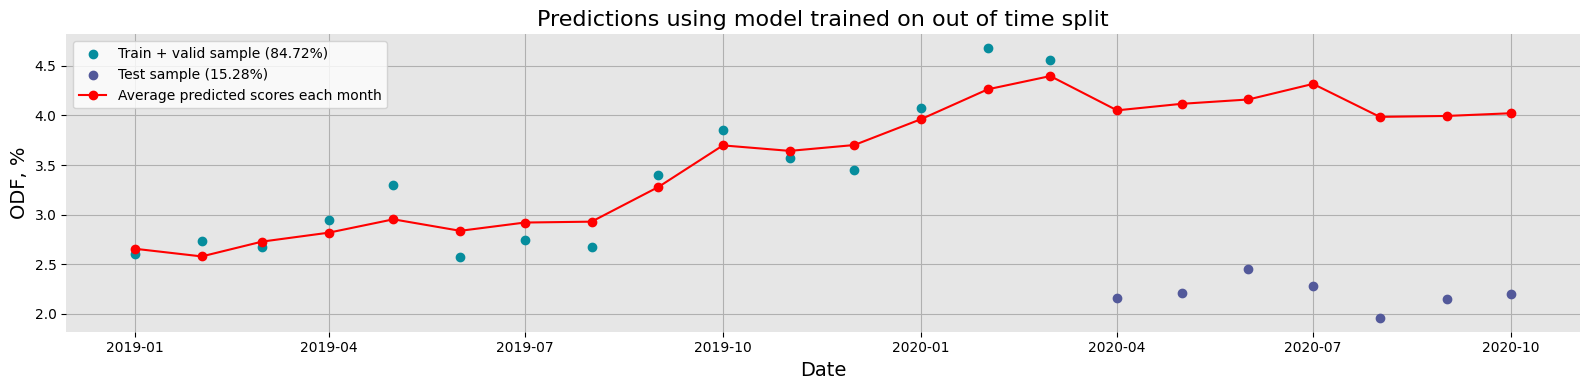

In [15]:
# select data for plotting
df_plot = pd.concat([ALL_MODELS["OOT_basic"]["data"]["base_train"],
                     ALL_MODELS["OOT_basic"]["data"]["base_valid"],
                     ALL_MODELS["OOT_basic"]["data"]["base_test"]])
df_plot = df_plot.groupby('MONTH').agg({'target': ['mean', 'count'], "pred": ['mean']}).reset_index()
df_plot.columns = ["".join(_) for _ in df_plot.columns]
# convert to date
df_plot['Date'] = pd.to_datetime(df_plot['MONTH'], format='%Y%m', errors='coerce')

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

_size = df_plot.loc[df_plot.MONTH < 202004, "targetcount"].sum() / df_plot["targetcount"].sum() * 100
ax.scatter(df_plot.loc[df_plot.MONTH < 202004, "Date"], df_plot.loc[df_plot.MONTH < 202004, "targetmean"] * 100,  label = f"Train + valid sample ({_size:.2f}%)")
ax.scatter(df_plot.loc[df_plot.MONTH >= 202004, "Date"], df_plot.loc[df_plot.MONTH >= 202004, "targetmean"] * 100, label = f"Test sample ({100-_size:.2f}%)")

# plot average predictions
ax.plot(df_plot["Date"], df_plot["predmean"] * 100, "o-", label = "Average predicted scores each month", color = "red", zorder = 10)

ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("ODF, %", fontsize = 14)

ax.set_title("Predictions using model trained on out of time split", fontsize = 16)

# add white background to legend
legend = ax.legend(frameon=1)
frame = legend.get_frame()
frame.set_facecolor('w')

plt.tight_layout()

<a id="3.2.2"></a>
## <b>3.2.2 <span style='color:#53599A'>Random splitting</span></b>

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [16]:
%%time
# select IDs for training
case_ids = data["case_id"].unique().shuffle(seed=SEED)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

# select data for different samples
base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

# convert columns to strings
for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)
    
# save results to dict
random_split_data = {"base_train": base_train, "X_train": X_train, "y_train": y_train,
                     "base_valid": base_valid, "X_valid": X_valid, "y_valid": y_valid,
                     "base_test": base_test, "X_test": X_test, "y_test": y_test}

CPU times: user 6.24 s, sys: 1.44 s, total: 7.68 s
Wall time: 5.35 s


In [17]:
%%time
# rs - random split
rs_lgb_train = lgb.Dataset(random_split_data["X_train"], label=random_split_data["y_train"])
rs_lgb_valid = lgb.Dataset(random_split_data["X_valid"], label=random_split_data["y_valid"], reference=rs_lgb_train)

# use the same params for random spliting
PARAMS = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm_rs = lgb.train(
    PARAMS,
    rs_lgb_train,
    valid_sets = rs_lgb_valid,
    callbacks = [lgb.log_evaluation(50), lgb.early_stopping(10)]
)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.70667
[100]	valid_0's auc: 0.724606
[150]	valid_0's auc: 0.73204
[200]	valid_0's auc: 0.73639
[250]	valid_0's auc: 0.740167
[300]	valid_0's auc: 0.742824
[350]	valid_0's auc: 0.744789
[400]	valid_0's auc: 0.746553
[450]	valid_0's auc: 0.748384
[500]	valid_0's auc: 0.749629
[550]	valid_0's auc: 0.750398
[600]	valid_0's auc: 0.751359
[650]	valid_0's auc: 0.752228
[700]	valid_0's auc: 0.752926
[750]	valid_0's auc: 0.753724
[800]	valid_0's auc: 0.754507
[850]	valid_0's auc: 0.755134
[900]	valid_0's auc: 0.755546
Early stopping, best iteration is:
[929]	valid_0's auc: 0.755772
CPU times: user 4min 52s, sys: 2.65 s, total: 4min 54s
Wall time: 1min 32s


In [18]:
# add model and data which was trained on out of time sample
ALL_MODELS['RANDOM_basic'] = {"model": gbm_rs, "data": random_split_data,
                              "lgb_train": rs_lgb_train, "lgb_valid": rs_lgb_valid}

In [19]:
%%time
make_predictions(gbm_model = ALL_MODELS["RANDOM_basic"]["model"], gbm_data = ALL_MODELS["RANDOM_basic"]["data"])

CPU times: user 1min 10s, sys: 134 ms, total: 1min 10s
Wall time: 18.3 s


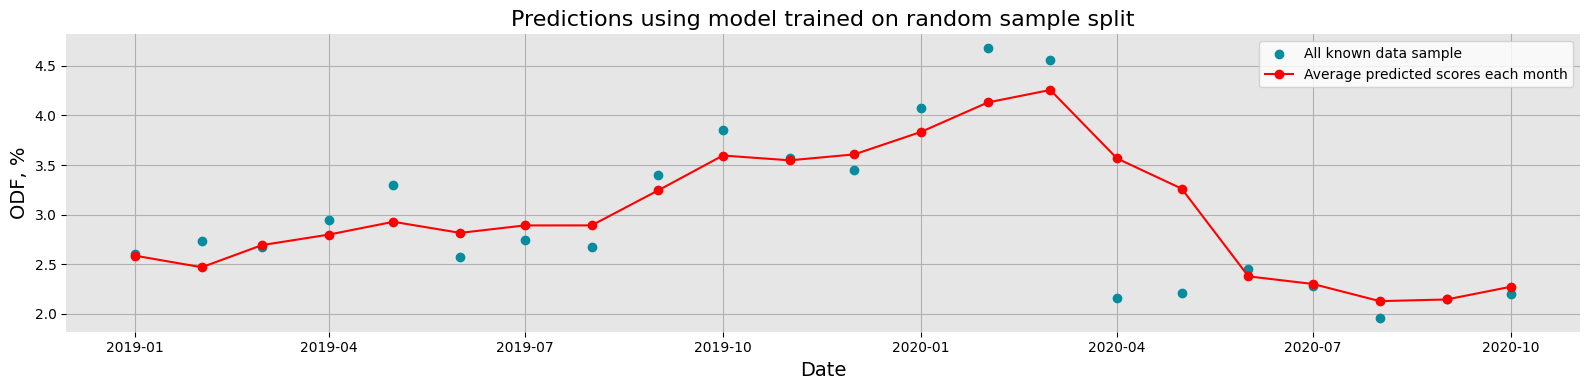

In [20]:
# select data for plotting
df_plot = pd.concat([ALL_MODELS["RANDOM_basic"]["data"]["base_train"],
                     ALL_MODELS["RANDOM_basic"]["data"]["base_valid"],
                     ALL_MODELS["RANDOM_basic"]["data"]["base_test"]])
df_plot = df_plot.groupby('MONTH').agg({'target': ['mean', 'count'], "pred": ['mean']}).reset_index()
df_plot.columns = ["".join(_) for _ in df_plot.columns]
# convert to date
df_plot['Date'] = pd.to_datetime(df_plot['MONTH'], format='%Y%m', errors='coerce')

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

ax.scatter(df_plot["Date" ], df_plot["targetmean"] * 100, label = "All known data sample")

# plot average predictions
ax.plot(df_plot["Date"], df_plot["predmean"] * 100, "o-", label = f"Average predicted scores each month", color = "red", zorder = 10)

ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("ODF, %", fontsize = 14)

ax.set_title("Predictions using model trained on random sample split", fontsize = 16)

# add white background to legend
legend = ax.legend(frameon=1)
frame = legend.get_frame()
frame.set_facecolor('w')

plt.tight_layout()

<a id="3.2.3"></a>
## <b>3.2.3 <span style='color:#53599A'>Compare splits</span></b>

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [21]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    """
    Sligtly modified function from notebook:
    https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook
    """
    # calculate weekly gini
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "pred"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "pred"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["pred"])-1)
    
    # calculate monthly gini
    gini_in_time_m = base.loc[:, ["MONTH", "target", "pred"]]\
        .sort_values("MONTH")\
        .groupby("MONTH")[["target", "pred"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["pred"])-1)
    
    # TODO: refractor this code chunk
    x = gini_in_time.index.values
    y = gini_in_time.tolist()
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    
    # calculate competition score
    score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std
    
    # TODO: refractor this code chunk
    x_m = np.arange(gini_in_time_m.shape[0])
    y_m = gini_in_time_m.tolist()
    a_m, b_m = np.polyfit(x_m, y_m, 1)
    y_hat_m = a_m*x_m + b_m
    residuals_m = y_m - y_hat_m
    res_std_m = np.std(residuals_m)
    avg_gini_m = np.mean(gini_in_time_m)
    
    # calculate competition score
    score_m = avg_gini_m + w_fallingrate * min(0, a_m) + w_resstd * res_std_m
    
    # return average GINI scores DataFrame object
    gini_in_time = gini_in_time.reset_index().rename(columns = {0: "gini"})
    gini_in_time_m = gini_in_time_m.reset_index().rename(columns = {0: "gini"})
    gini_in_time_m['MONTH'] = pd.to_datetime(gini_in_time_m['MONTH'], format='%Y%m', errors='coerce')
    
    # return results as dictonary
    results = {
        # weekly
        "gini_in_time": gini_in_time,
        "avg_gini": avg_gini,
        "w_fallingrate": w_fallingrate,
        "a": a,
        "b": b,
        "w_resstd": w_resstd,
        "res_std": res_std,
        "score": score,
        # monthly
        "gini_in_time_m": gini_in_time_m,
        "avg_gini_m": avg_gini_m,
        "a_m": a_m,
        "b_m": b_m,
        "res_std_m": res_std_m,
        "score_m": score_m,
    }
    
    return results

In [22]:
# calculate stabitlity scores (ss) for different models and datasets
ss_oot_train = gini_stability(ALL_MODELS["OOT_basic"]["data"]["base_train"])
ss_oot_valid = gini_stability(ALL_MODELS["OOT_basic"]["data"]["base_valid"])
ss_oot_test = gini_stability(ALL_MODELS["OOT_basic"]["data"]["base_test"])

ss_rs_train = gini_stability(ALL_MODELS["RANDOM_basic"]["data"]["base_train"])
ss_rs_valid = gini_stability(ALL_MODELS["RANDOM_basic"]["data"]["base_valid"])
ss_rs_test = gini_stability(ALL_MODELS["RANDOM_basic"]["data"]["base_test"])

In [23]:
# Out-off-time split
print(f'The stability score on the train set using out-of-time split is: {ss_oot_train["score"]:.3f}')
print(f'The stability score on the valid set using out-of-time split is: {ss_oot_valid["score"]:.3f}')
print(f'The stability score on the test set using out-of-time split is: {ss_oot_test["score"]:.3f}\n')

# Random split
print(f'The stability score on the train set using random split is: {ss_rs_train["score"]:.3f}')
print(f'The stability score on the valid set using random split is: {ss_rs_valid["score"]:.3f}')
print(f'The stability score on the test set using random split is: {ss_rs_test["score"]:.3f}') 

The stability score on the train set using out-of-time split is: 0.496
The stability score on the valid set using out-of-time split is: 0.451
The stability score on the test set using out-of-time split is: 0.495

The stability score on the train set using random split is: 0.509
The stability score on the valid set using random split is: 0.475
The stability score on the test set using random split is: 0.456


In [24]:
def add_gini(ax, data, row_idx, col_idx, label="unknown", time_col_nm="WEEK_NUM", a="", b=""):
    """
    Helper function for visualizing temporal gini score changes
    """
    # add temporal Gini score distributions
    ax[row_idx, col_idx].scatter(data[time_col_nm], data["gini"], label = label, color=COLORS[col_idx])
    # add fitted lines if value are provided
    if a != "":
        # dashed line y values
        if time_col_nm == "WEEK_NUM":
            _y = a * data[time_col_nm] + b
        else:
            _y = a * data[time_col_nm].index + b
        ax[row_idx, col_idx].plot(data[time_col_nm], _y,
                                  color="r", linestyle="--",
                                  label= "$G_{\mathrm{fit}}(i) =$" + f" {a:.3f} i + {b:.3f}")

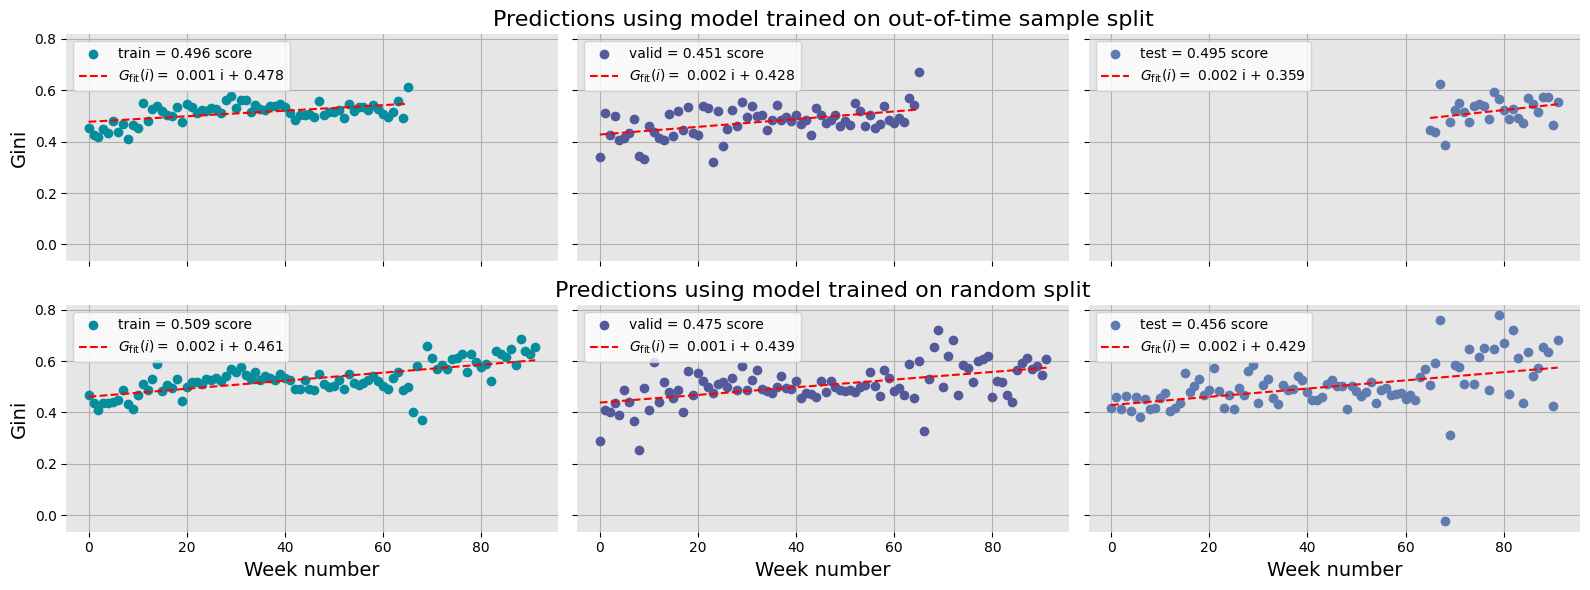

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6), sharex=True, sharey=True)

# out-of-time
add_gini(ax=ax, data=ss_oot_train["gini_in_time"], row_idx=0, col_idx=0, label=f"train = {ss_oot_train['score']:.3f} score", a=ss_oot_train['a'], b=ss_oot_train['b'])
add_gini(ax=ax, data=ss_oot_valid["gini_in_time"], row_idx=0, col_idx=1, label=f"valid = {ss_oot_valid['score']:.3f} score", a=ss_oot_valid['a'], b=ss_oot_valid['b'])
add_gini(ax=ax, data=ss_oot_test["gini_in_time"], row_idx=0, col_idx=2, label=f"test = {ss_oot_test['score']:.3f} score", a=ss_oot_test['a'], b=ss_oot_test['b'])

# random split
add_gini(ax=ax, data=ss_rs_train["gini_in_time"], row_idx=1, col_idx=0, label=f"train = {ss_rs_train['score']:.3f} score", a=ss_rs_train['a'], b=ss_rs_train['b'])
add_gini(ax=ax, data=ss_rs_valid["gini_in_time"], row_idx=1, col_idx=1, label=f"valid = {ss_rs_valid['score']:.3f} score", a=ss_rs_valid['a'], b=ss_rs_valid['b'])
add_gini(ax=ax, data=ss_rs_test["gini_in_time"], row_idx=1, col_idx=2, label=f"test = {ss_rs_test['score']:.3f} score", a=ss_rs_test['a'], b=ss_rs_test['b'])

# add titles
ax[0, 1].set_title("Predictions using model trained on out-of-time sample split", fontsize = 16)
ax[1, 1].set_title("Predictions using model trained on random split", fontsize = 16)

for i in range(2):
    ax[i, 0].set_ylabel("Gini", fontsize = 14)
for i in range(3):
    ax[1, i].set_xlabel("Week number", fontsize = 14)

# add white background to legend
for i in range(2):
    for ii in range(3):
        legend = ax[i, ii].legend(frameon=1)
        frame = legend.get_frame()
        frame.set_facecolor('w')

plt.tight_layout()

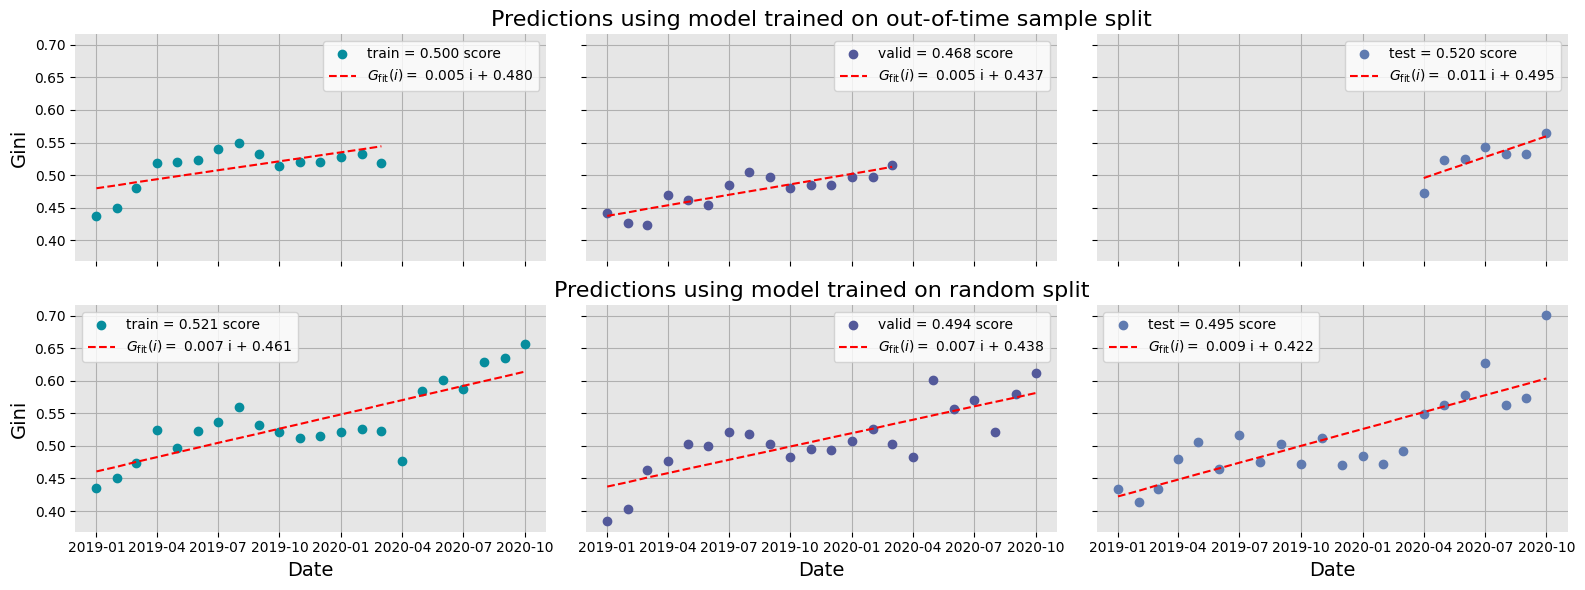

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6), sharex=True, sharey=True)

# out-of-time
add_gini(ax=ax, data=ss_oot_train["gini_in_time_m"], row_idx=0, col_idx=0, label=f"train = {ss_oot_train['score_m']:.3f} score", time_col_nm="MONTH", a=ss_oot_train['a_m'], b=ss_oot_train['b_m'])
add_gini(ax=ax, data=ss_oot_valid["gini_in_time_m"], row_idx=0, col_idx=1, label=f"valid = {ss_oot_valid['score_m']:.3f} score", time_col_nm="MONTH", a=ss_oot_valid['a_m'], b=ss_oot_valid['b_m'])
add_gini(ax=ax, data=ss_oot_test["gini_in_time_m"], row_idx=0, col_idx=2, label=f"test = {ss_oot_test['score_m']:.3f} score", time_col_nm="MONTH", a=ss_oot_test['a_m'], b=ss_oot_test['b_m'])

# random split
add_gini(ax=ax, data=ss_rs_train["gini_in_time_m"], row_idx=1, col_idx=0, label=f"train = {ss_rs_train['score_m']:.3f} score", time_col_nm="MONTH", a=ss_rs_train['a_m'], b=ss_rs_train['b_m'])
add_gini(ax=ax, data=ss_rs_valid["gini_in_time_m"], row_idx=1, col_idx=1, label=f"valid = {ss_rs_valid['score_m']:.3f} score", time_col_nm="MONTH", a=ss_rs_valid['a_m'], b=ss_rs_valid['b_m'])
add_gini(ax=ax, data=ss_rs_test["gini_in_time_m"], row_idx=1, col_idx=2, label=f"test = {ss_rs_test['score_m']:.3f} score", time_col_nm="MONTH", a=ss_rs_test['a_m'], b=ss_rs_test['b_m'])

# add titles
ax[0, 1].set_title("Predictions using model trained on out-of-time sample split", fontsize = 16)
ax[1, 1].set_title("Predictions using model trained on random split", fontsize = 16)

for i in range(2):
    ax[i, 0].set_ylabel("Gini", fontsize = 14)
for i in range(3):
    ax[1, i].set_xlabel("Date", fontsize = 14)

# add white background to legend
for i in range(2):
    for ii in range(3):
        legend = ax[i, ii].legend(frameon=1)
        frame = legend.get_frame()
        frame.set_facecolor('w')

plt.tight_layout()

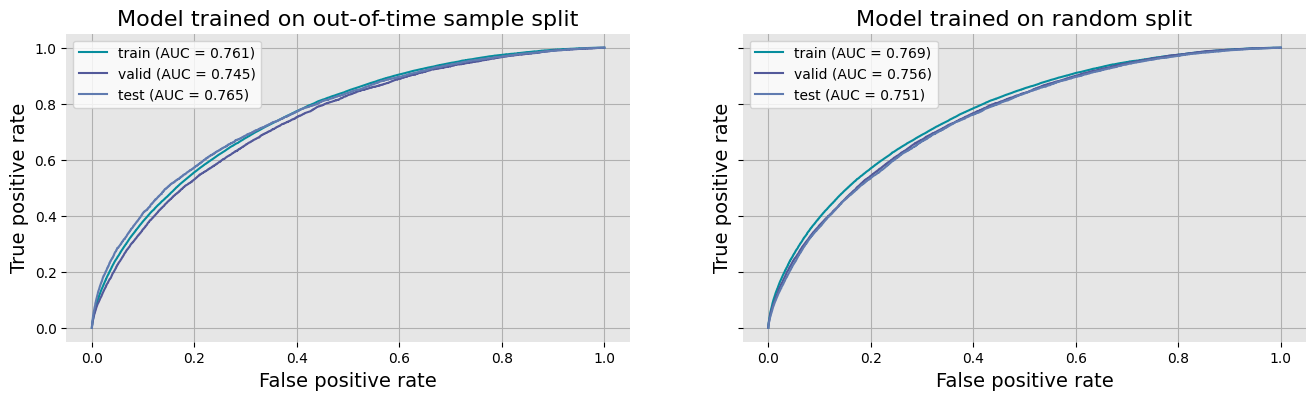

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

for __ in ['base_train', 'base_valid', 'base_test']:
    _df = ALL_MODELS["OOT_basic"]["data"][__]
    fpr, tpr, _ = roc_curve(y_true=_df["target"], y_score=_df["pred"])
    _auc = roc_auc_score(_df["target"], _df["pred"])
    ax[0].plot(fpr, tpr, label = f'{__.split("_")[1]} (AUC = {_auc:.3f})')
    
    _df = ALL_MODELS["RANDOM_basic"]["data"][__]
    fpr, tpr, _ =roc_curve(y_true=_df["target"], y_score=_df["pred"])
    _auc = roc_auc_score(_df["target"], _df["pred"])
    ax[1].plot(fpr, tpr, label = f'{__.split("_")[1]} (AUC = {_auc:.3f})')
    
    
# add titles
ax[0].set_title("Model trained on out-of-time sample split", fontsize = 16)
ax[1].set_title("Model trained on random split", fontsize = 16)

for i in range(2):
    # add white background to legend
    legend = ax[i].legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    # add labels
    ax[i].set_xlabel("False positive rate", fontsize = 14)
    ax[i].set_ylabel("True positive rate", fontsize = 14)

<a id="4"></a>
# <b>4 <span style='color:#53599A'>Modeling</span></b>

**TODO**

For now use models trained in [3.2 Train/test/valid split](#3.2) section in the validation section.

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

<a id="5"></a>
# <b>5 <span style='color:#53599A'>Model validation</span></b>

Diagnostic charts and tables for the final model which is used to make predictions in the submission section.

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [28]:
def validate_model(data, chart = True):
    """
    Input:
        preds, array like object
        target, array like object
        chart, boolean, if true return matplolib else table of summary statistics
    Output:
        pandas DataFrame or matplolib object
        
    Needs equal length prediction and taget column vectors
    """
    # create DataFrame for plotting and summary stats
    _df = data.copy()
    _roc = data.loc[:, ["WEEK_NUM", "target", "pred"]]\
                   .sort_values("WEEK_NUM").groupby("WEEK_NUM")[["target", "pred"]]\
                   .apply(lambda x: roc_auc_score(x["target"], x["pred"]))
    _df['ROC_AUC'] = _df['WEEK_NUM'].map(_roc)
    _df['GINI'] = 2 * _df['ROC_AUC'] - 1
    
    # stability score
    x = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['WEEK_NUM']
    y = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI']
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].mean()
    w_fallingrate = 88.0
    w_resstd = -0.5 
    # calculate competition score
    score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std
    
    if chart:
        fig, ax = plt.subplots(2, 2, figsize=(16, 10))
        
        # temporal changes of gini scores
        _df_plot = _df.groupby('WEEK_NUM')['GINI'].mean().reset_index()
        ax[0, 0].plot(_df_plot['WEEK_NUM'], _df_plot['GINI'], "o-", label = 'Weekly GINI scores')
        # add linear fit
        ax[0, 0].plot(_df_plot['WEEK_NUM'], _df_plot['WEEK_NUM'] * a + b, "r--", label = 'linear fit')
        ax[0, 0].set_ylabel("Gini score")
        ax[0, 0].set_xlabel("Week number")
        
        # GINI score boxplot
        sns.boxplot(data=_df_plot, x="GINI", ax = ax[0, 1], color = COLORS[2])
        ax[0, 1].set_xlabel("Gini score")
        
        # GINI score histogram
        ax[1, 1].hist(_df_plot['GINI'], bins=20, label="Weekly GINI scores", color = COLORS[2])
        ax[1, 1].set_ylabel("Count")
        ax[1, 1].set_xlabel("Gini score")
        
        # GINI vs number of observations
        _df_plot = _df.groupby('WEEK_NUM').agg({"GINI": ['mean', "count"]})
        ax[1, 0].scatter(_df_plot.iloc[:, 0],_df_plot.iloc[:, 1], label = f'Corr. {_df_plot.corr().values[0, 1]:.3f}', color = COLORS[1])
        ax[1, 0].set_xlabel("Weekly Gini score")
        ax[1, 0].set_ylabel("Number of applications")
        
        # add white backgrounds to legends
        for i in range(2):
            for ii in range(2):
                legend = ax[i, ii].legend(frameon=1)
                frame = legend.get_frame()
                frame.set_facecolor('w')
        
    # return DataFrame with summary stats
    else:
        _df_stats = pd.DataFrame({"dataset": ["valid"]})
        _df_stats['Avg. weekly ROC AUC'] = _df[['WEEK_NUM', 'ROC_AUC']].drop_duplicates()['ROC_AUC'].mean().round(3)
        _df_stats['Std. of weekly ROC AUC'] = _df[['WEEK_NUM', 'ROC_AUC']].drop_duplicates()['ROC_AUC'].std().round(3)
        _df_stats['Avg. weekly GINI'] = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].mean().round(3)
        _df_stats['Std. of weekly GINI'] = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].std().round(3)
        _df_stats['Stability score'] = round(score, 3)
        
        return _df_stats

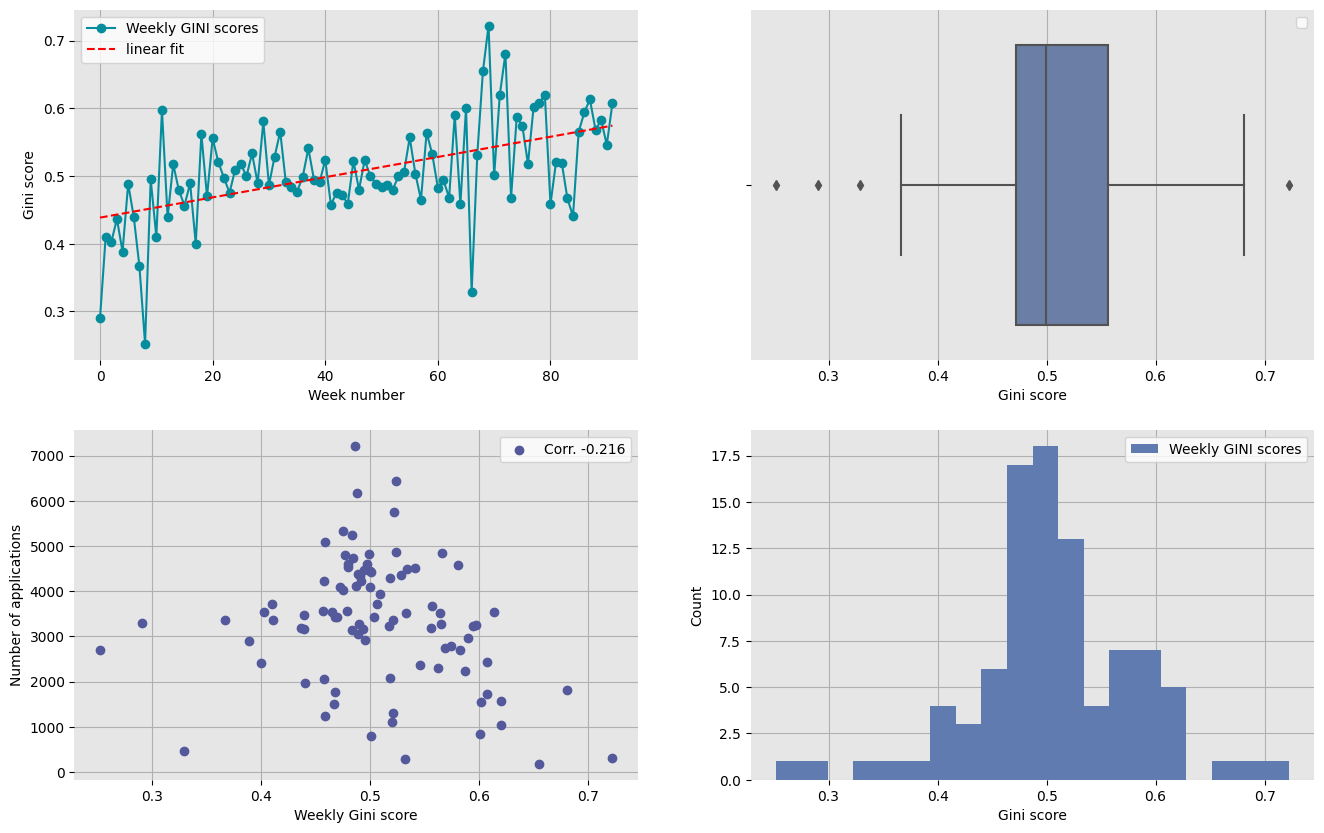

In [29]:
_data = ALL_MODELS["RANDOM_basic"]["data"]['base_valid'].copy()
validate_model(_data)

In [30]:
validate_model(_data, False)

,dataset,Avg. weekly ROC AUC,Std. of weekly ROC AUC,Avg. weekly GINI,Std. of weekly GINI,Stability score
0,valid,0.753,0.038,0.507,0.075,0.475


<a id="6"></a>
# <b>6 <span style='color:#53599A'>Submit predictions</span></b>

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>

In [31]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)
categorical_cols = X_train.select_dtypes(include=['category']).columns

for col in categorical_cols:
    train_categories = set(X_train[col].cat.categories)
    submission_categories = set(X_submission[col].cat.categories)
    new_categories = submission_categories - train_categories
    X_submission.loc[X_submission[col].isin(new_categories), col] = "Unknown"
    new_dtype = pd.CategoricalDtype(categories=train_categories, ordered=True)
    X_train[col] = X_train[col].astype(new_dtype)
    X_submission[col] = X_submission[col].astype(new_dtype)

In [32]:
# model for making predicitons
final_model = ALL_MODELS["RANDOM_basic"]["model"]
y_submission_pred = final_model.predict(X_submission, num_iteration=final_model.best_iteration)

In [33]:
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')
submission.to_csv("./submission.csv")

<a id="7"></a>
# <b>7 <span style='color:#53599A'>Changelog</span></b>

* **v1** added basic data loading and processing code from https://www.kaggle.com/code/jetakow/home-credit-2024-starter-notebook notebook by @jetakow. Created general structure for the upcomming notebook.
* **v2** added basic descriptions from TTC and PIT PD models. In addition, created visualizations for the provided historical default data. An example section was created that visually differeces between models trained on out-of-time and random samples.
* **v3** remade a chart in [3.1 Historical default rate](#3.1) section. Sligthly re-fractored code to have one dictornary with all train/valid/test samples and trained models so it is easier to compare multiple approaches (work still in progress).
* **v4** finished re-fractoring model code - now all data and trained models are saved into dictonary for easy comparison. Added new [3.2.3 Compare splits](#3.2.3) sub-section for comparing 2 models trained on different sample spliting using competition stability equation. As expected, model trained on random sample scored better on stability score.
* **v5** compared two trained models using the gini stability score. These scores were also visualized using weekly and monthly time scales. I have also added references for previous TODO placeholders.
* **v6** calculated stability scores on monthly data. Added fitted score lines on stability score (inspired by @eliocordeiropereira notebook: https://www.kaggle.com/code/eliocordeiropereira/the-starter-notebook-thoroughly-explained) and ROC charts in [3.2.3 Compare splits](#3.2.3) sub-section.
* **v7** fixed small code typos with the last 2 charts in notebook version 6.
* **v8** added submission using model which was trained on out-of-time sample.
* **v9** added diagnostic charts and tables in the validation section and turned-off the internet so one can submit predictions from the notebook.

<a id="8"></a>
# <b><span style='color:#53599A'>Refencences</span></b>

<a id="ref1"><b>[1]</b></a> Basle Committee on Bank Supervision. (2000). Range of Practice in Banks? Internal Ratings Systems. Discussion paper January, Basel, Switzerland.
<br>
<a id="ref2"><b>[2]</b></a> Supervisory handbook on the validation of rating systems under the internal ratings based approach, last update 10 August 2023.

<div>
<br>
<a href="#toc" style="background-color: #607BB0; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;">Back to top</a><a id="toc"></a>
</div>